In [6]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import warnings
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('dataset_57_hypothyroid.csv')
data.replace('?', np.nan, inplace=True)
# Параметры ниже константны (TBG = NaN)
data.drop(['TBG_measured', 'TBG'], axis=1, inplace=True)
data.dropna(subset=['Class'], axis=0, inplace=True)

In [8]:
data.shape

(3772, 28)

In [9]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... T3_measured  \
0        f               f              f                 f  ...           t   
1        f               f              f                 f  ...           t   
2        f               f              f                 f  ...           f   
3        f               f              f                 f  ...           t   
4        f               f              f                 f  ...           t   

    T3 TT4_measured  TT4 T4U_measured   T4U FTI_measured  FTI referral_source  \
0  2.5            t  125            t  1.14            t  109            SVHC   
1    2            t  102            f   NaN            f  NaN           other   
2  NaN            t  109            t  0.91            t  120           other   
3  1.9            t  175            f   NaN            f  NaN           other   
4  1.2            t   61            t  0.87            t   70             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 28 columns]

In [10]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='ignore')

In [11]:
report = ProfileReport(data)
report.to_notebook_iframe()

## Выводы по EDA

Target в выборке несбалансирован. Accuracy для метрики не подойдет. Так как задача касается здоровья, наилучшим вариантом будут метрики с несимметричными ошибками точность и полнота. Числовые значения будут заполены средним значением, категориальные most frequent. <br>
Категориальные признаки будут заменены с  использованием One-Hot encoder <br>
В данных также есть повторяющиеся строки, от которых следует избавиться

In [12]:
bool_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col][0] in ['t', 'f']]
for col in bool_cols:
    data[col] = data[col] == 't'

In [13]:
data.drop_duplicates()
y = data['Class']
data.drop('Class', axis = 1, inplace=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train)

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Pipeline для предобработки данных

### Состоит из:
<ul>
    <li>Заполнение пропусков в числовых и категориальных значений</li>
    <li>Кодирование категориальных признаков</li>
    <li>Далее Pipeline соберется в другой, содержащий модель</li>
</ul>

In [16]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_cols = [col for col in data.columns if data[col].dtype =='object']
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]



preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
], remainder='passthrough')

In [17]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, precision_score, log_loss, f1_score


# логистическая регрессия без регуляризации
model = LogisticRegression(penalty='none')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

logistic_pipeline.fit(X_train, y_train)

preds = logistic_pipeline.predict(X_valid)
prob_preds=logistic_pipeline.predict_proba(X_valid)

new_c = [col for col in X_train.columns if X_train[col].dtype != 'object']
new_c.extend(logistic_pipeline['preprocessor'].transformers_[1][1]['encoder'].get_feature_names())

logloss  0.20896174979447102
Полнота  0.5544070103794453
Точность  0.6338884730538922
F1  0.5872022086654495


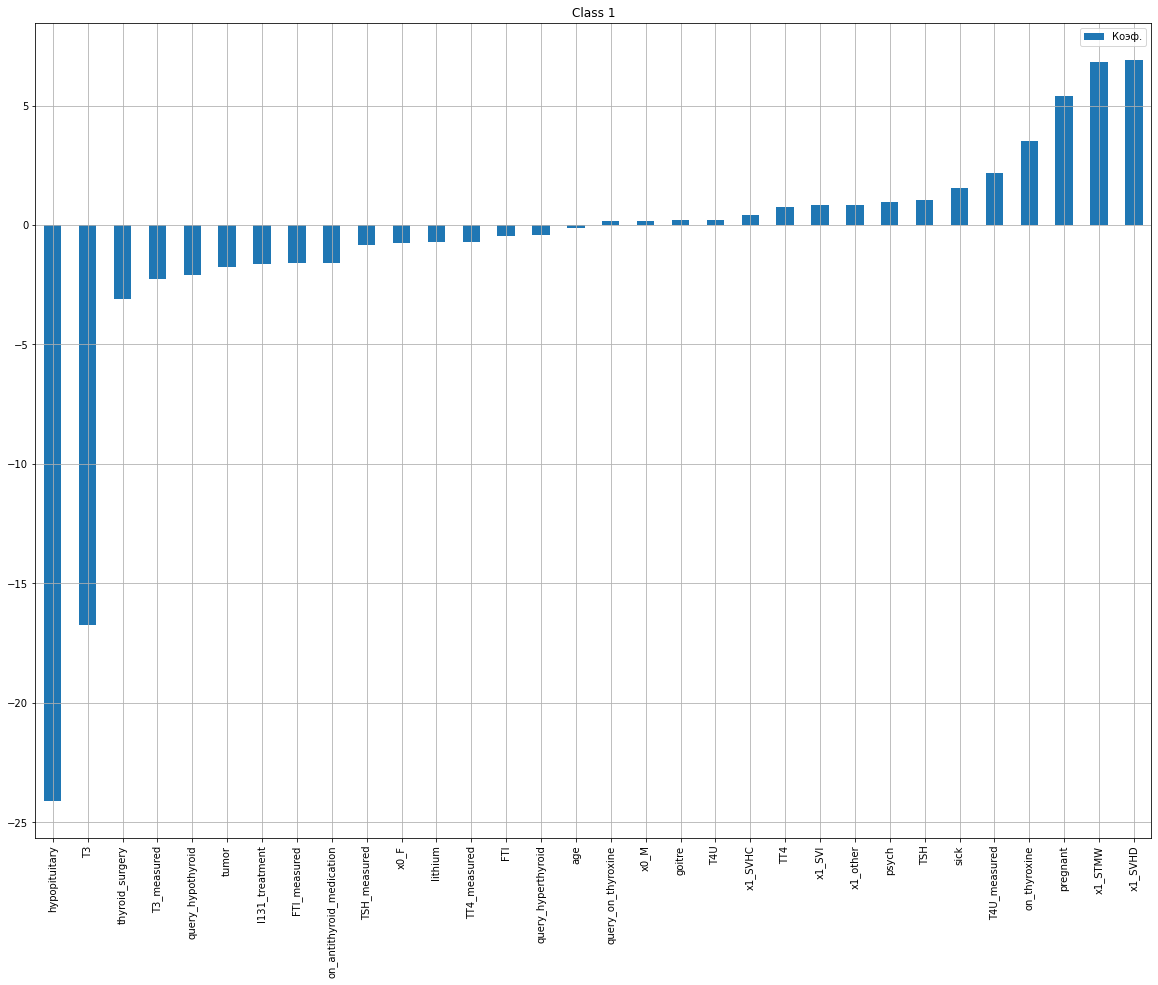

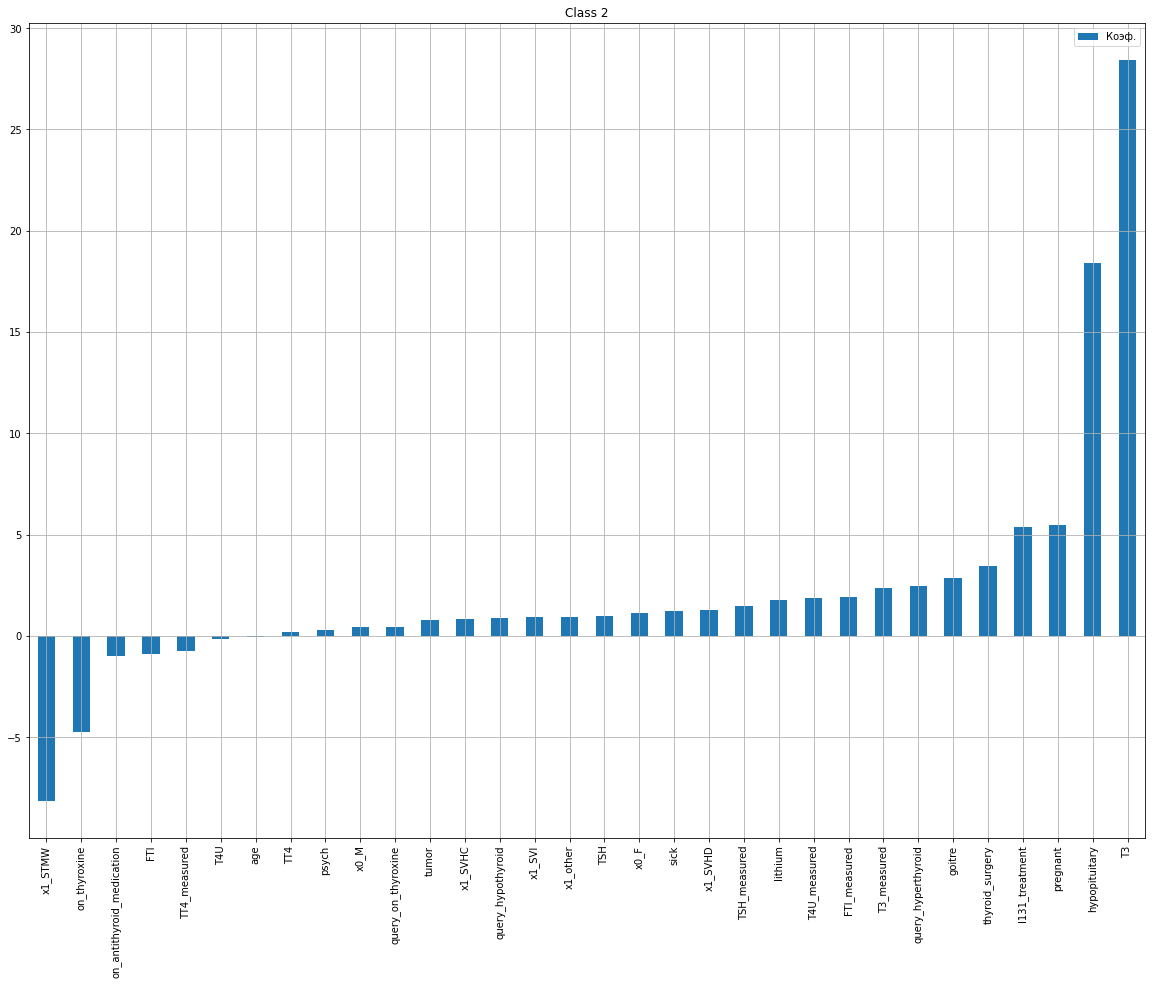

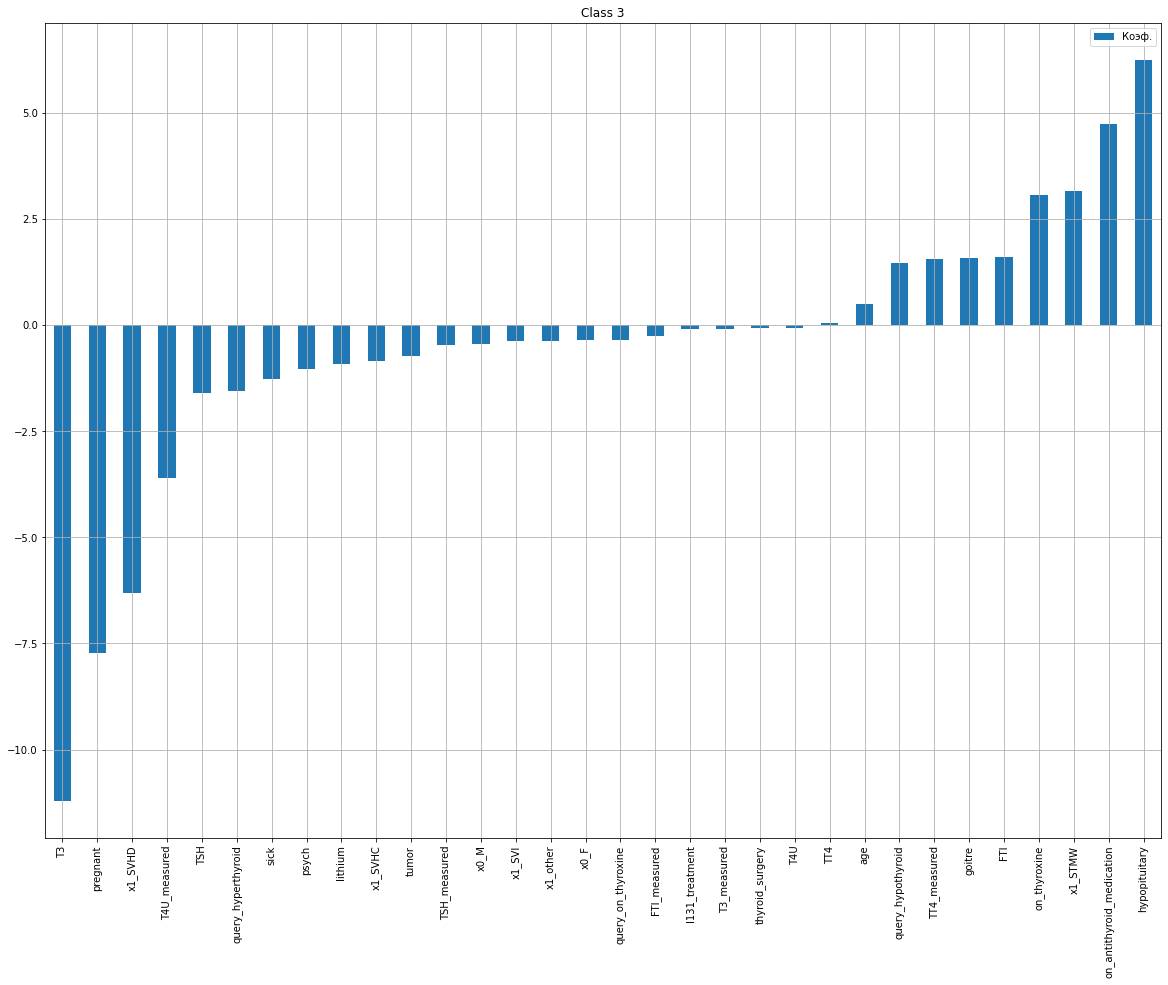

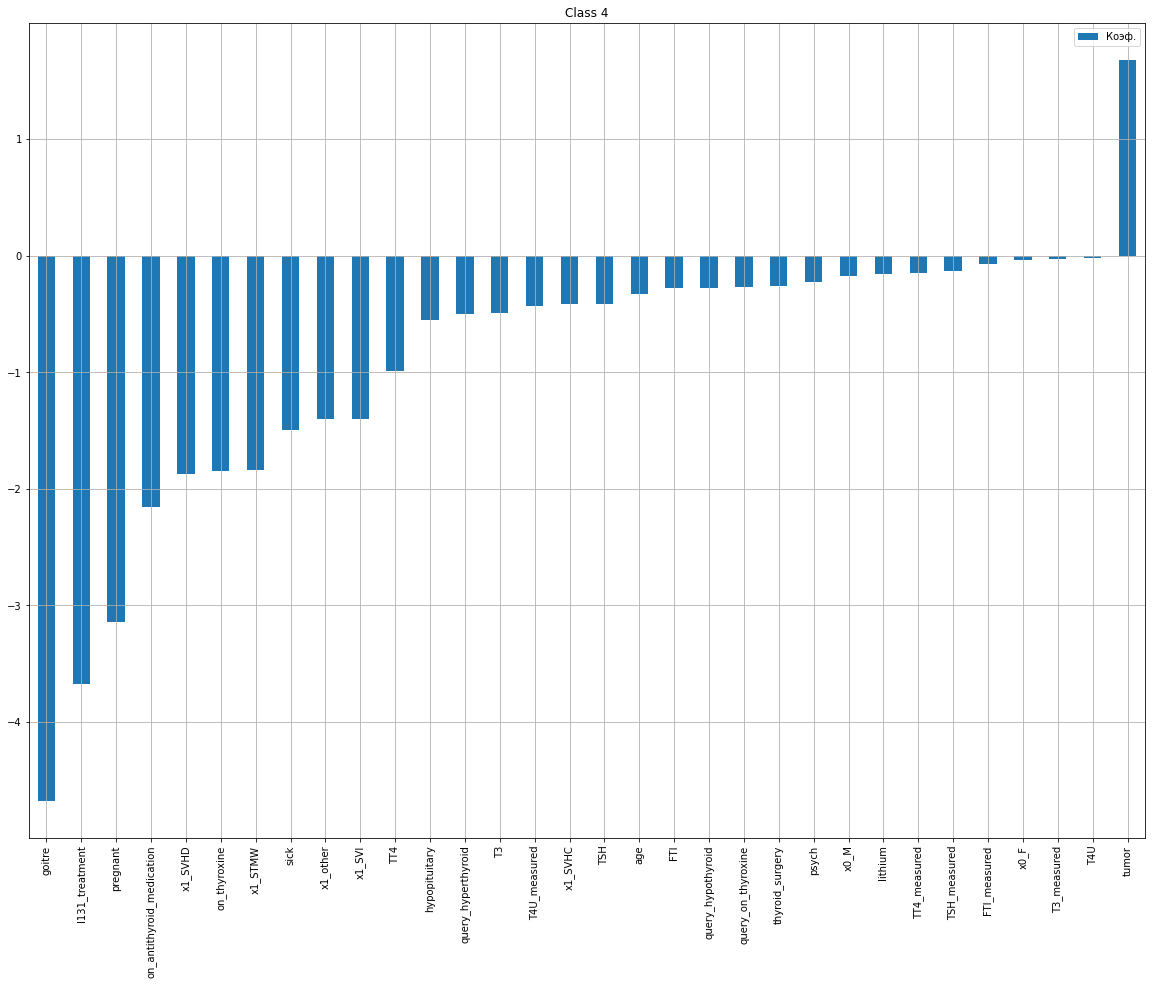

In [18]:
print('logloss ', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ', precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(20, 15))

## Логистическая регрессия с разными видами регуляризации


### L1

logloss 0.13479073041502915
Полнота  0.5544070103794453
Точность  0.6338884730538922
F1  0.5872022086654495


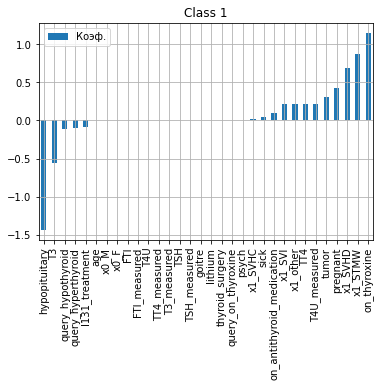

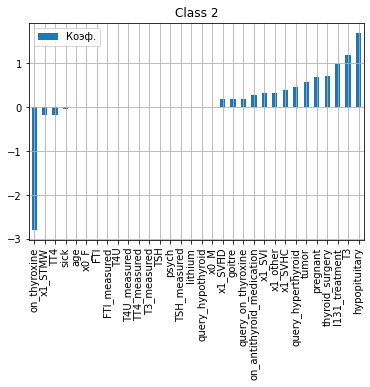

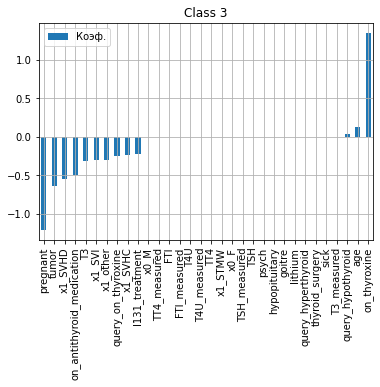

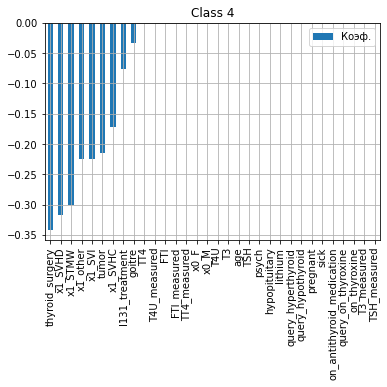

In [19]:
model = LogisticRegression(solver = 'saga' ,penalty='l1')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

Нелинейные изменения

Самым значим численным параметром, при регуляризации L1 , является T3 , добавил квадрат T3

In [20]:
X_train['T3^2'] = X_train['T3'] ** 2
X_valid['T3^2'] = X_valid['T3'] ** 2
X_test['T3^2'] = X_test['T3'] ** 2

In [21]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_cols = [col for col in X_train.columns if X_train[col].dtype =='object']
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]



preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
], remainder='passthrough')

new_c = [col for col in X_train.columns if X_train[col].dtype != 'object']
new_c.extend(logistic_pipeline['preprocessor'].transformers_[1][1]['encoder'].get_feature_names())

In [22]:
X_train['T3^2'].dtype

dtype('float64')

logloss 0.13204643708103944
Полнота  0.5200676365492598
Точность  0.6612132352941177
F1  0.5585242818057455


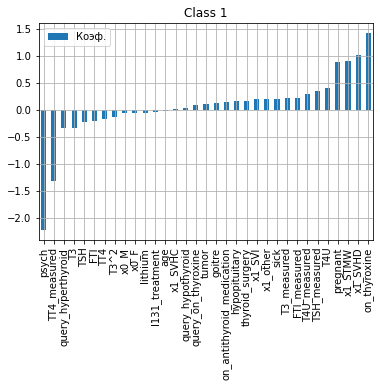

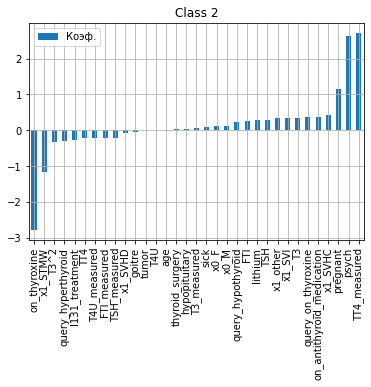

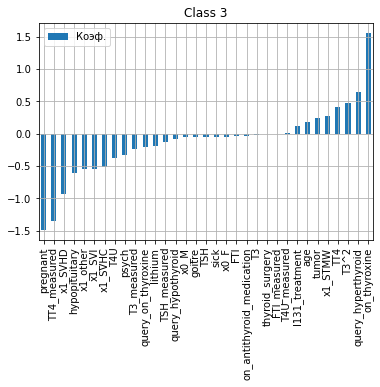

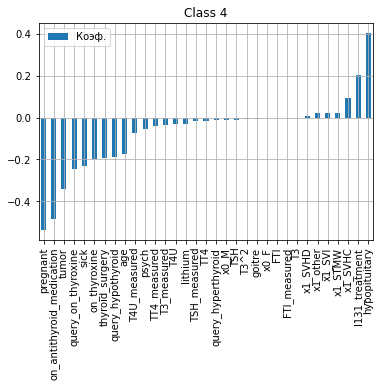

In [23]:
model = LogisticRegression(penalty='l2')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_valid)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

###  Elastic net

logloss 0.13572020188770456
Полнота  0.5204504849412965
Точность  0.682748538011696
F1  0.5394643895952795


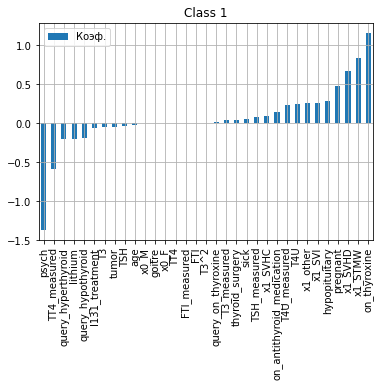

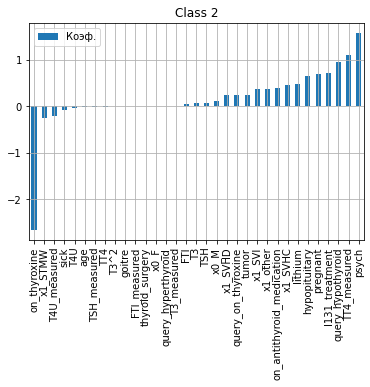

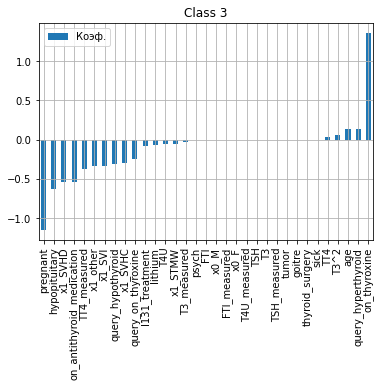

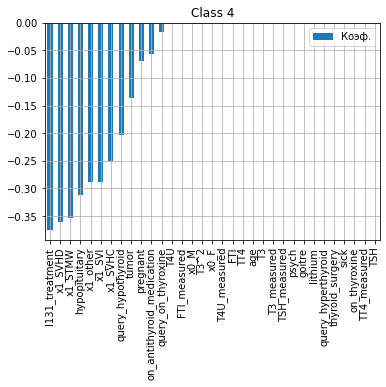

In [24]:
model = LogisticRegression(solver = 'saga' ,penalty='elasticnet', l1_ratio=0.5)
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_valid)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

## Выводы
Так как в задаче речь идет о здоровье человека, в этом случае будет выгодным взять модель с регуляризацией <b>L2</b>, так как этот вариант имеет наибольшую полноту, то есть наилучшим образом определяет больных. 

## Кросс-валидация для L2

In [27]:
from sklearn.model_selection import cross_val_score

for i in np.arange(0, 2, 0.1):
    model = LogisticRegression(penalty='l2', C=i)
    logistic_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ])
    scores = cross_val_score(logistic_pipeline, X_train, y_train, cv=5, scoring='f1_macro')
    print('C = ', round(i, 1), scores, np.mean(scores))

C =  0.0 [0.0246085  0.0328849  0.03146067 0.0328849  0.0328849 ] 0.030944776759210195
C =  0.1 [0.46341427 0.62335757 0.65416635 0.72647135 0.64047573] 0.6215770562695042
C =  0.2 [0.49139651 0.62335757 0.67847902 0.70359231 0.66059524] 0.6314841309418979
C =  0.3 [0.49139651 0.66629062 0.72033604 0.70359231 0.66059524] 0.6484421448077995
C =  0.4 [0.49139651 0.6900882  0.69135053 0.70359231 0.68152432] 0.6515903759041481
C =  0.5 [0.49139651 0.6900882  0.67081036 0.70359231 0.68152432] 0.6474823414441921
C =  0.6 [0.49139651 0.6900882  0.66096065 0.72192226 0.70108605] 0.6530907358227427
C =  0.7 [0.46506683 0.7093784  0.66096065 0.72192226 0.70108605] 0.6516828385273378
C =  0.8 [0.46506683 0.7051885  0.66096065 0.70879616 0.7366206 ] 0.6553265484286671
C =  0.9 [0.49139651 0.7051885  0.66096065 0.71268845 0.7366206 ] 0.6613709450080733
C =  1.0 [0.49139651 0.7051885  0.66096065 0.73604517 0.7366206 ] 0.666042288989762
C =  1.1 [0.49139651 0.7051885  0.66096065 0.73604517 0.7417547 

Наилучшие результаты возникают при C = 1.7

# KNN

In [201]:
?KNeighborsClassifier

In [202]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

model = KNeighborsClassifier(algorithm='kd_tree')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.13060734756075726
Полнота  0.6315615960524077
Точность  0.7109692634363687
F1  0.6663453950118237


In [203]:
model = KNeighborsClassifier(algorithm='brute')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.13060734756075726
Полнота  0.6315615960524077
Точность  0.7109692634363687
F1  0.6663453950118237


In [204]:
model = KNeighborsClassifier(algorithm='ball_tree')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.13060734756075726
Полнота  0.6315615960524077
Точность  0.7109692634363687
F1  0.6663453950118237
